In [104]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow

In [105]:
print(tensorflow.__version__)

2.7.0


In [106]:
# from google.colab import drive
# drive.mount('/content/drive')

In [107]:
label_data = pd.read_csv("/content/drive/MyDrive/kamp-ai 스마트제조 인공지능 경진대회/labeled.csv")

In [108]:
label_data['EQUIP_NAME'].value_counts()

# 결과는 아래에서 확인 가능

650톤-우진2호기    7992
1800TON-우진       2
650톤-우진          2
Name: EQUIP_NAME, dtype: int64

In [109]:
label_data['PART_NAME'].value_counts()

# 결과는 아래에서 확인 가능

CN7 W/S SIDE MLD'G RH        3371
CN7 W/S SIDE MLD'G LH        3365
RG3 MOLD'G W/SHLD, RH         628
RG3 MOLD'G W/SHLD, LH         628
JX1 W/S SIDE MLD'G RH           2
SP2 CVR ROOF RACK CTR, RH       2
Name: PART_NAME, dtype: int64

In [110]:
def make_input(data, machine_name, product_name):
  machine_ = data['EQUIP_NAME'] == machine_name
  product_ = data['PART_NAME'] == product_name
  data = data[machine_ & product_]

  # 불필요한 컬럼
  # pandas package의 라이브러리인 drop을 통해 지정 열 제거

  data.drop(['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'Reason',
             'PART_FACT_SERIAL', 'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME',
             
             # 아래는 값이 0인 칼럼들
             'Mold_Temperature_1','Mold_Temperature_2','Mold_Temperature_5',
             'Mold_Temperature_6', 'Mold_Temperature_7', 'Mold_Temperature_8',
             'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_Temperature_11',
             'Mold_Temperature_12', 'Barrel_Temperature_7', 'Switch_Over_Position'],
             axis=1, inplace=True)
  return data

In [111]:
# 데이터 호기 종류
machine_name = "650톤-우진2호기"

# 데이터 제품 종류
product_name = ["CN7 W/S SIDE MLD'G LH", "CN7 W/S SIDE MLD'G RH",
                "RG3 MOLD'G W/SHLD, LH", "RG3 MOLD'G W/SHLD, RH"]

In [112]:
machine_name

'650톤-우진2호기'

In [113]:
product_name

["CN7 W/S SIDE MLD'G LH",
 "CN7 W/S SIDE MLD'G RH",
 "RG3 MOLD'G W/SHLD, LH",
 "RG3 MOLD'G W/SHLD, RH"]

In [114]:
# 650톤-우진2호기의 "CN7 W/S SIDE MLD'G LH" 데이터만 변수를 제거
cn7lh = make_input(label_data, machine_name, product_name[0])

# 650톤-우진2호기의 "CN7 W/S SIDE MLD'G RH" 데이터만 변수를 제거
cn7rh = make_input(label_data, machine_name, product_name[1])

# 650톤-우진2호기의 "RG3 MOLD'G W/SHLD, LH" 데이터만 변수를 제거
rg3lh = make_input(label_data, machine_name, product_name[2])

# 650톤-우진2호기의 "RG3 MOLD'G W/SHLD RH" 데이터만 변수를 제거
rg3rh = make_input(label_data, machine_name, product_name[3])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [115]:
# 동일한 제품의 LH와 RH는 합쳐줌

cn7 = pd.concat([cn7lh, cn7rh], ignore_index=True)
rg3 = pd.concat([rg3lh, rg3rh], ignore_index=True)

In [116]:
# rg3에는 'Plasticizing_Position' 변수값이 모두 0이므로 추가적으로 삭제
# rg3.drop(['Plasticizing_Position'], axis=1, inplace=True)

In [117]:
# 양품 Y를 0, 불량 N을 1로 치환
cn7['PassOrFail'] = cn7['PassOrFail'].replace('Y', 0).replace('N', 1)

In [118]:
cn7.describe()

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,Max_Screw_RPM,Average_Screw_RPM,Max_Injection_Pressure,Max_Switch_Over_Pressure,Max_Back_Pressure,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
count,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000
mean,0.005790,9.580064,4.448425,16.820433,59.549314,7.113639,653.440859,68.381941,644.899046,55.523085,30.674674,125.583744,142.090559,136.518646,37.842132,59.347209,275.965024,275.134961,274.858091,270.285823,254.924346,229.971512,66.663094,22.074228,23.473619
std,0.075876,0.180526,0.140286,0.288946,0.372267,0.075843,0.115004,0.648307,42.170577,1.005340,0.141148,126.836972,1.985764,0.754736,1.768085,3.530820,2.302366,1.887356,1.854329,2.018081,1.134566,0.428762,2.433782,1.171389,1.370780
min,0.000000,9.360000,3.350000,16.469999,58.840000,6.070000,653.390015,59.759998,69.639999,38.500000,30.299999,29.200001,140.699997,128.399994,21.700001,13.300000,244.699997,249.000000,249.600006,244.399994,239.699997,224.600006,38.500000,19.100000,20.600000
25%,0.000000,9.530000,4.420000,16.629999,59.480000,7.120000,653.429993,68.320000,647.989990,55.099998,30.600000,29.200001,141.800003,136.300003,37.599998,59.400002,275.799988,275.000000,274.799988,269.700012,254.800003,229.800003,65.599998,21.200001,22.600000
50%,0.000000,9.570000,4.450000,16.820000,59.520000,7.120000,653.429993,68.360001,647.989990,55.400002,30.700001,29.200001,141.899994,136.500000,37.900002,59.500000,276.100006,275.299988,275.000000,270.399994,255.000000,230.000000,67.000000,21.900000,23.299999
75%,0.000000,9.600000,4.480000,16.910000,59.540001,7.120000,653.440002,68.510002,647.989990,55.900002,30.799999,292.399994,142.100006,136.800003,38.200001,59.700001,276.399994,275.500000,275.200012,271.100006,255.199997,230.100006,67.800003,22.799999,24.200001
max,1.000000,13.390000,8.270000,21.100000,64.349998,7.180000,655.000000,68.860001,647.989990,64.800003,31.200001,293.899994,169.100006,146.699997,75.199997,90.800003,277.899994,276.500000,276.000000,272.399994,256.299988,230.699997,70.599998,25.299999,27.799999


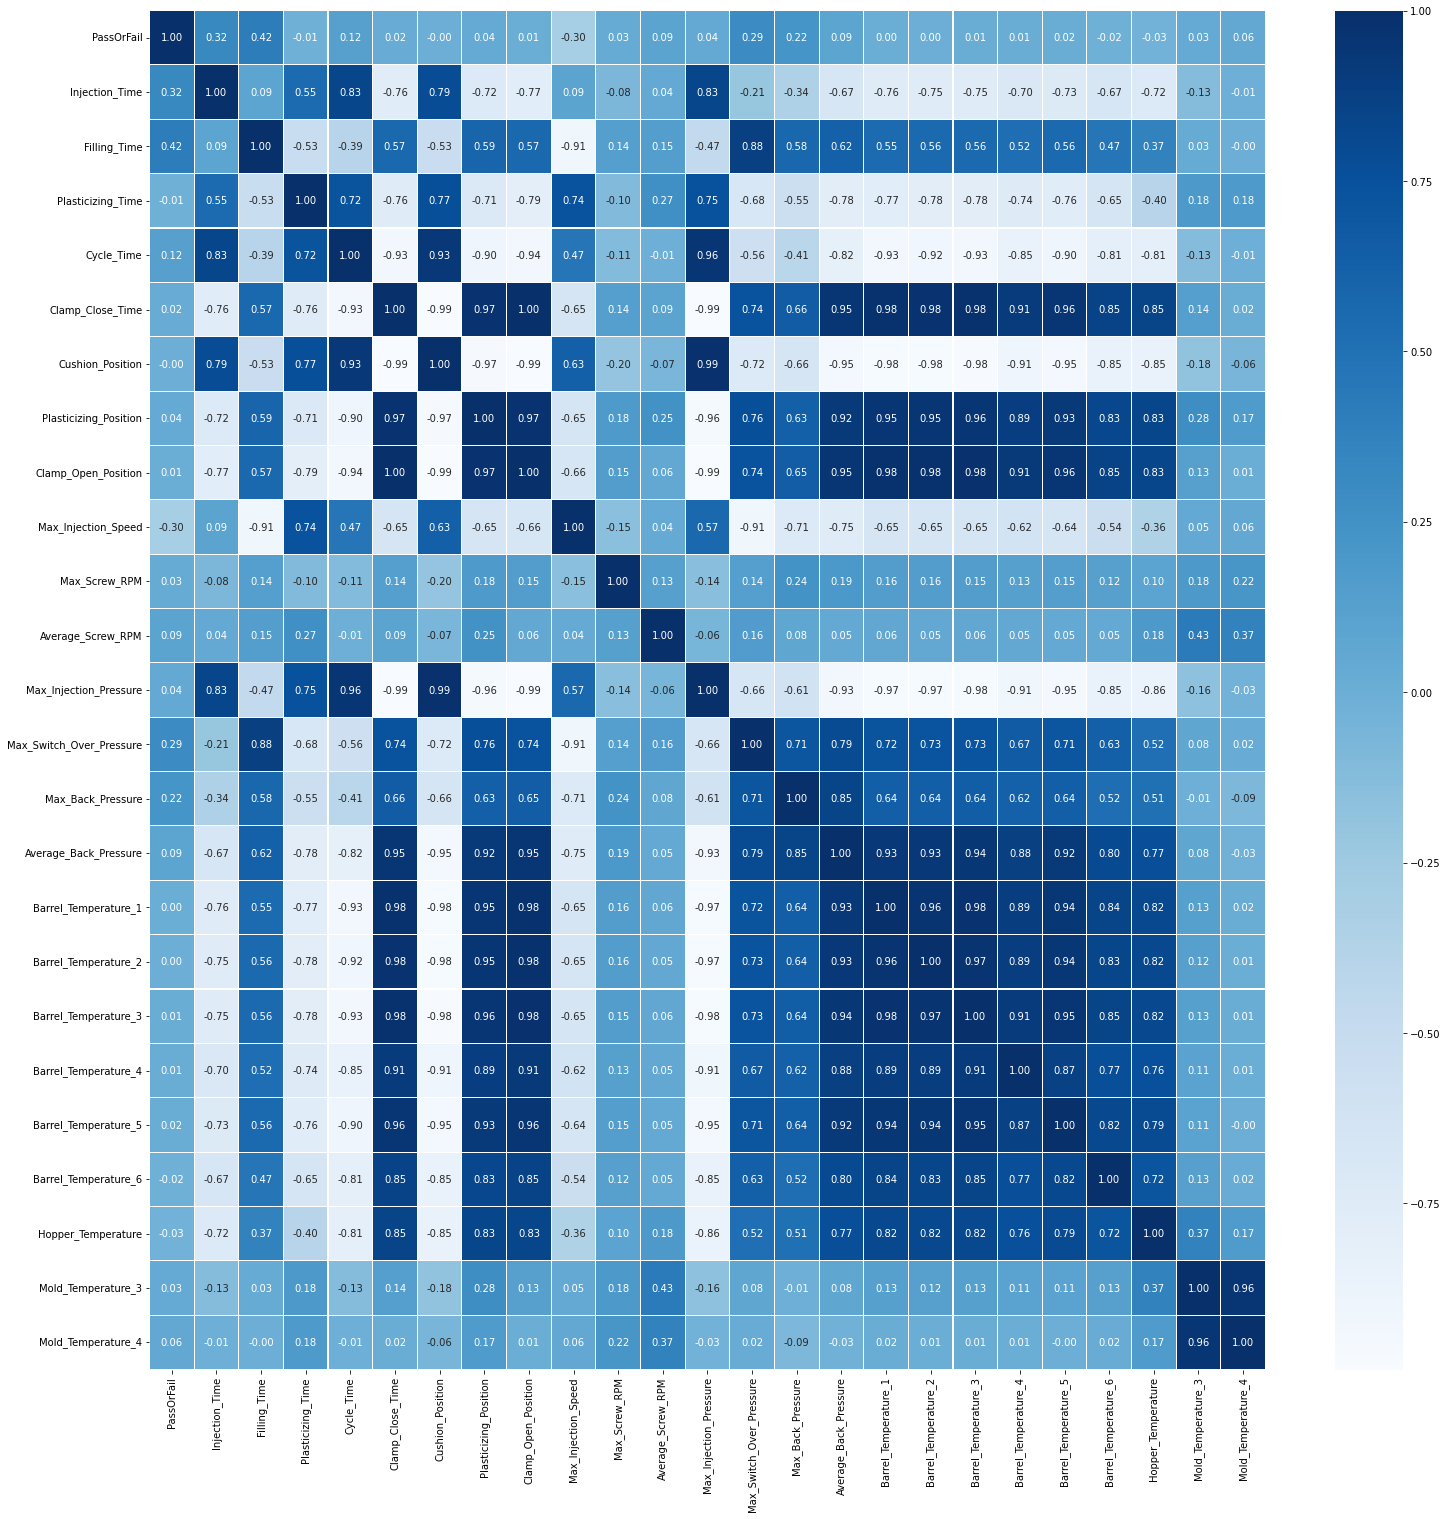

In [119]:
plt.subplots(figsize=(25,25))
sns.heatmap(data = cn7.corr(),linewidths = 0.1, annot=True, fmt = '.2f', cmap='Blues')

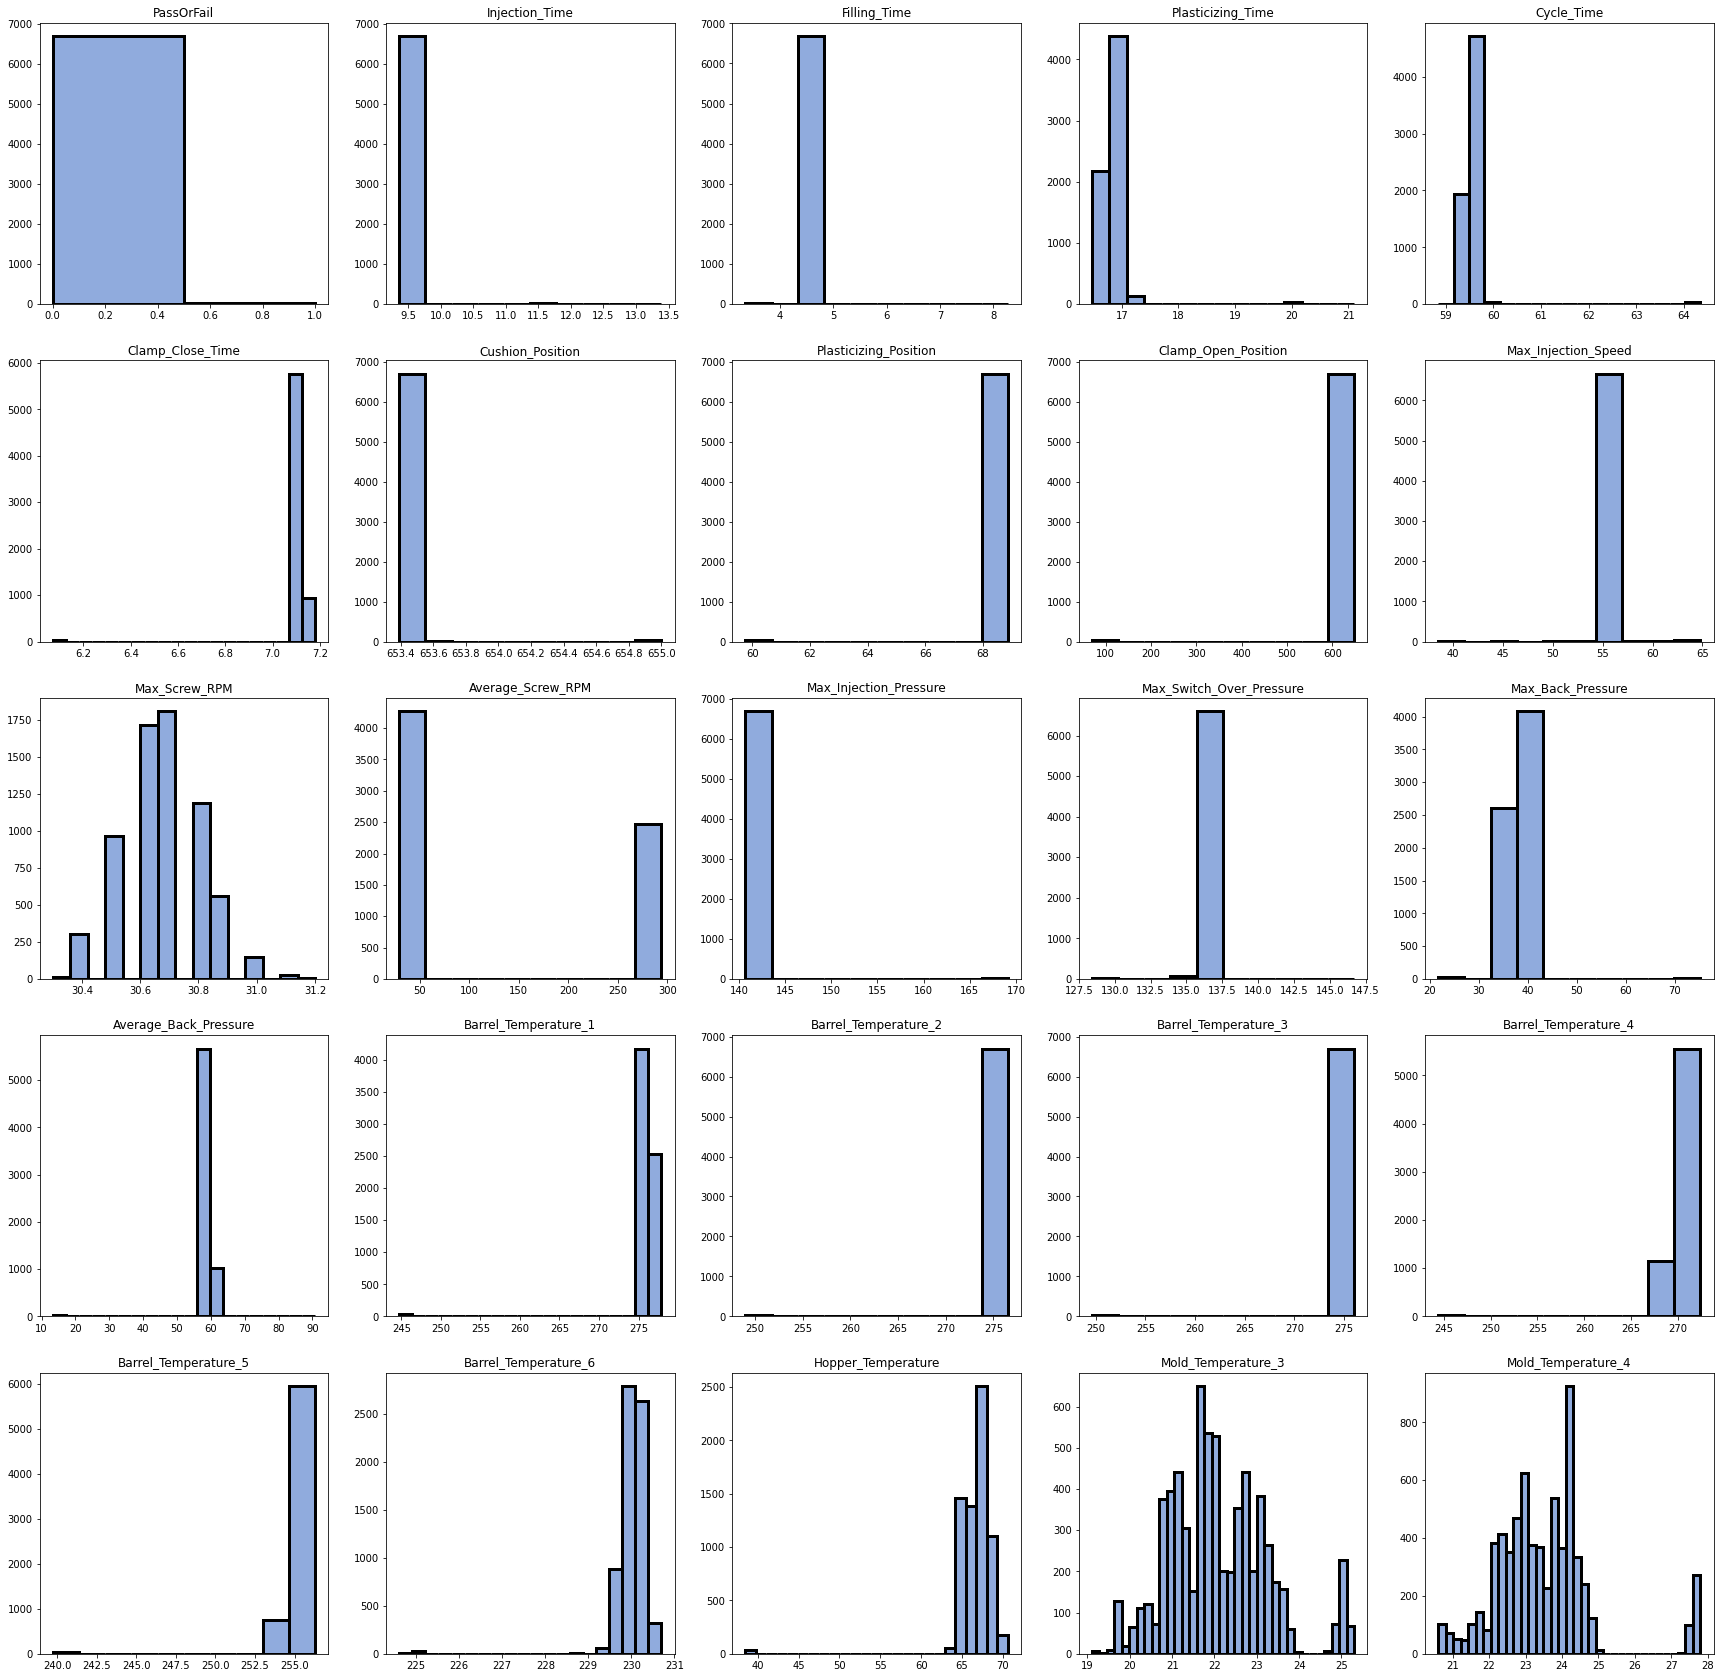

In [120]:
plt.figure(figsize=(30,30))

# 각 변수의 막대그래프 개수
bin = [2,10,10,15,17,20,10,10,10,10,15,10,10,10,10,20,20,10,10,10,10,20,25,35,35]

for index, value in enumerate(cn7):
  sub = plt.subplot(5,5,index+1)
  sub.hist(cn7[value], bins = bin[index], facecolor = (144/255,171/255,221/255), linewidth=3, edgecolor='black')
  plt.title(value)
  # 결과 확인은 아래

In [121]:
# 양품 및 불량 데이터 파악
cn7['PassOrFail'].value_counts()

0    6697
1      39
Name: PassOrFail, dtype: int64

In [122]:
# 데이터 분리 및 불필요한 데이터 제거
# 양품
cn7_Y = cn7[cn7['PassOrFail']==0]
print('CN7의 양품 개수:', len(cn7_Y))

# 불량
cn7_N = cn7[cn7['PassOrFail']==1]
print('CN7의 불량 개수:', len(cn7_N))

CN7의 양품 개수: 6697
CN7의 불량 개수: 39


In [123]:
# 오토인코더에 학습시킬 데이터는 클래스 변수가 없어야 함
# 양품
cn7_Y.drop(['PassOrFail'], axis=1, inplace=True)

# 불량
cn7_N.drop(['PassOrFail'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [124]:
cn7_Y

,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,Max_Screw_RPM,Average_Screw_RPM,Max_Injection_Pressure,Max_Switch_Over_Pressure,Max_Back_Pressure,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,9.60,4.48,16.910000,59.580002,7.13,653.409973,68.839996,647.98999,55.299999,30.799999,292.500000,141.800003,136.899994,37.500000,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.600000
1,9.59,4.48,16.910000,59.560001,7.13,653.419983,68.839996,647.98999,55.299999,31.000000,292.500000,141.800003,136.800003,37.500000,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.600000
2,9.58,4.46,16.900000,59.580002,7.13,653.409973,68.839996,647.98999,55.599998,30.900000,292.500000,141.699997,136.399994,37.700001,59.400002,276.299988,275.299988,275.200012,271.399994,255.000000,230.000000,67.500000,25.000000,27.600000
3,9.58,4.46,16.920000,59.560001,7.13,653.409973,68.849998,647.98999,55.500000,30.600000,292.399994,141.800003,136.699997,37.400002,59.299999,275.799988,275.399994,275.000000,271.299988,255.000000,230.000000,67.000000,25.000000,27.600000
4,9.57,4.45,16.910000,59.520000,7.14,653.409973,68.830002,647.98999,55.700001,30.799999,292.500000,141.600006,136.399994,37.099998,59.099998,275.700012,274.899994,274.799988,270.799988,255.399994,230.100006,66.699997,24.799999,27.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6731,9.58,4.46,16.670000,59.520000,7.11,653.429993,68.339996,647.98999,55.200001,30.600000,29.200001,142.199997,136.399994,37.900002,59.700001,275.799988,275.500000,275.500000,269.500000,255.000000,230.199997,66.000000,21.000000,22.400000
6732,9.60,4.49,16.650000,59.540001,7.11,653.429993,68.320000,647.98999,54.900002,30.799999,29.200001,142.100006,136.899994,38.099998,59.799999,276.100006,275.899994,274.899994,269.700012,254.600006,229.600006,65.400002,21.000000,22.400000
6733,9.60,4.48,16.620001,59.560001,7.11,653.429993,68.330002,647.98999,54.900002,30.700001,29.200001,142.100006,137.000000,38.299999,59.900002,276.500000,274.899994,275.100006,269.500000,255.600006,229.600006,66.099998,21.000000,22.400000
6734,9.60,4.48,16.650000,59.560001,7.11,653.429993,68.349998,647.98999,55.000000,30.700001,29.200001,142.100006,136.800003,38.400002,59.900002,275.799988,275.299988,275.500000,270.700012,254.899994,230.000000,66.099998,21.000000,22.400000


In [126]:
cn7_N

,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,Max_Screw_RPM,Average_Screw_RPM,Max_Injection_Pressure,Max_Switch_Over_Pressure,Max_Back_Pressure,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
23,9.58,4.47,16.889999,59.520000,7.13,653.409973,68.839996,647.98999,55.400002,30.600000,292.500000,141.800003,136.600006,37.599998,59.400002,276.100006,275.200012,275.100006,271.399994,255.199997,230.199997,67.800003,25.000000,27.500000
57,9.45,4.33,16.959999,59.580002,7.13,653.400024,68.839996,647.98999,60.700001,30.799999,292.500000,141.399994,136.800003,37.099998,59.099998,275.299988,275.299988,275.100006,269.799988,255.000000,230.100006,68.000000,25.000000,27.700001
58,9.45,4.33,16.930000,59.419998,7.13,653.400024,68.839996,647.98999,60.900002,30.900000,292.500000,141.399994,136.899994,36.299999,58.700001,276.700012,274.899994,274.899994,270.399994,254.899994,229.800003,67.000000,25.100000,27.700001
59,9.44,4.33,16.920000,59.439999,7.13,653.400024,68.860001,647.98999,60.799999,30.700001,292.500000,141.399994,137.000000,36.500000,58.799999,276.000000,275.200012,274.799988,271.100006,254.699997,229.800003,67.000000,25.100000,27.600000
639,13.39,8.27,16.650000,59.560001,7.12,653.630005,68.589996,647.98999,38.500000,30.799999,292.399994,147.399994,146.699997,38.099998,59.700001,275.799988,275.299988,275.299988,270.000000,255.699997,229.699997,64.400002,20.400000,21.700001
642,10.83,5.72,16.820000,62.360001,7.18,653.390015,68.580002,647.98999,45.400002,31.100000,292.399994,144.899994,142.699997,71.900002,87.099998,276.000000,274.799988,275.700012,268.899994,255.199997,229.800003,63.799999,20.600000,21.799999
643,11.49,6.37,16.750000,62.360001,7.18,653.429993,68.589996,647.98999,45.099998,30.500000,292.500000,145.699997,144.199997,43.700001,62.900002,275.200012,275.500000,274.899994,272.100006,255.199997,230.100006,64.300003,20.500000,21.799999
644,9.98,4.87,16.530001,60.459999,7.12,653.409973,68.610001,647.98999,49.400002,30.700001,292.500000,142.899994,139.000000,50.599998,67.400002,276.000000,275.299988,275.100006,271.600006,255.199997,229.600006,65.000000,20.700001,22.000000
645,9.70,4.58,16.469999,58.959999,7.12,653.450012,68.589996,647.98999,53.299999,30.500000,292.299988,142.199997,137.399994,38.599998,60.200001,276.799988,275.100006,275.700012,270.899994,255.399994,229.399994,64.500000,20.600000,21.900000
1769,9.60,4.48,16.580000,59.520000,7.11,653.429993,68.360001,647.98999,55.000000,30.600000,29.200001,142.100006,136.800003,38.299999,59.900002,277.299988,275.200012,274.899994,271.500000,255.100006,230.100006,65.300003,22.200001,24.000000


In [127]:
# MinMaxScaler를 통한 데이터 정규화
# raw data를 스케일링 함
# 변수마다 수치의 크기와 평균, 분산 등의 통계치가 다르고, 특히 지나치게 낮거나
# 높은 값인 아웃라이어가 존재할 수 있으므로 모델의 성능에 악영향을 미칠 수 있음
# 스케일링을 통해 모델의 성능을 제거하고 데이터를 정제하는 결괄르 얻게 됨
scaler = MinMaxScaler()
# 양품
cn7_Y = scaler.fit_transform(cn7_Y)
# 불량
cn7_N = scaler.fit_transform(cn7_N)

In [128]:
cn7_Y

array([[0.1132079 , 0.76870742, 0.08515271, ..., 0.89408094, 0.91935482,
        0.97222238],
       [0.10849081, 0.76870742, 0.08515271, ..., 0.88473529, 0.95161302,
        0.97222238],
       [0.10377372, 0.75510199, 0.08296925, ..., 0.90342683, 0.95161302,
        0.97222238],
       ...,
       [0.1132079 , 0.76870742, 0.02183414, ..., 0.85981308, 0.30645161,
        0.24999993],
       [0.1132079 , 0.76870742, 0.0283841 , ..., 0.85981308, 0.30645161,
        0.24999993],
       [0.1132079 , 0.76870742, 0.02401718, ..., 0.83177565, 0.30645161,
        0.23611099]])

In [129]:
cn7_N

array([[0.03544312, 0.03553296, 0.85714341, 0.16470621, 0.28571526,
        0.08316378, 0.95999146, 0.        , 0.7544643 , 0.1666672 ,
        1.        , 0.06666819, 0.04716985, 0.03651683, 0.02464792,
        0.4285735 , 0.31250477, 0.57143169, 0.78124702, 0.68749821,
        0.80000305, 0.8510645 , 0.95833318, 0.96666654],
       [0.0025317 , 0.        , 1.        , 0.18235367, 0.28571526,
        0.04170905, 0.95999146, 0.        , 0.9910714 , 0.49999841,
        1.        , 0.        , 0.0660375 , 0.02247189, 0.01408443,
        0.04760798, 0.37499046, 0.57143169, 0.28124702, 0.5624994 ,
        0.70001221, 0.89361704, 0.95833318, 1.        ],
       [0.0025317 , 0.        , 0.93877797, 0.13529379, 0.28571526,
        0.04170905, 0.95999146, 0.        , 1.        , 0.66666561,
        1.        , 0.        , 0.07547061, 0.        , 0.        ,
        0.71429402, 0.12499046, 0.42856831, 0.46874821, 0.49999523,
        0.40000916, 0.68085112, 0.97916659, 1.        ],
       [0.   

In [130]:
# 학습 데이터와 평가데이터를 6:4의 비율로 분리
# 학습 데이터(양품)
cn7_train_Y = cn7_Y[:4000]
# 평가 데이터(양품)
cn7_test_Y = cn7_Y[4000:]
# 평가 데이터(불량)
cn7_test_N = cn7_N

print('CN7의 양품 학습 데이터셋 개수', len(cn7_train_Y))
print('CN7의 양품 학습 데이터셋 개수', len(cn7_test_Y))
print('CN7의 양품 학습 데이터셋 개수', len(cn7_test_N))
# 결과는 아래에서 확인 가능

CN7의 양품 학습 데이터셋 개수 4000
CN7의 양품 학습 데이터셋 개수 2697
CN7의 양품 학습 데이터셋 개수 39


In [131]:
# 오토인코더 모델 구축(잡음제거)
# ai 분석 모델 구축을 위한 방법론(알고리즘) 적용 및 학습 네트워크 구축 실습
# 잡음 제거 오토 인코더 모델 구축
# Tensorflow Keras package의 Sequential 모델을 사용하여 순서대로 연결된 층을 일렬로 쌓아 구성
# 인코더와 디코더, 두 개를 합친 오토인코더 모델을 구성 할때 Sequential을 사용
# 훈련에 필요한 계산과 모델을 표현한 구조를 구성하는 과정에서 입력층, 은닉층, 출력층의 크기와
# 학습 속도 및 드롭아웃 비율을 직접 설정해줄 수 있으며, 이렇게 직접 설정해주는 파라미터를
# 하이퍼파라미터라고 한다.

# 첫번째 레이어로 Dropout 은닉층을 추가
# 드롭아웃 비율을 0.3으로 설정
# 뉴런을 15개 혹은 5개를 가진 Dense 은닉층을 추가
# Relu 활성화 함수를 사용하여 층마다 각자 가중치 행렬을 관리라 함
# Relu 는 0보다 작은 입력은 0으로 만들고, 0보다 큰 입력은 그대로 내보내게 되면서
# 연산 비용을 줄임으로써 빠른 학습을 가능하게 함

In [133]:
# 인코더
dropout_encoder = Sequential([
                              Dropout(0.3),
                              Dense(15, activation='relu'), # 첫 번째 은닉층
                              Dense(5, activation='relu')   # 두 번째 은닉층
])

# 디코더
dropout_decoder = Sequential([
                              Dense(15, activation='relu', input_shape=[5]), # 세 번째 은닉층
                              Dense(cn7_train_Y.shape[1], activation='relu') # 출력
])

dropout_AE = Sequential([dropout_encoder, dropout_decoder])

In [134]:
# 손실함수, 옵티마이저 정의 모델 컴파일, 훈련
# 손실함수, 옵티마이저 정의
dropout_AE.compile(loss='mse', optimizer=Adam(lr=0.01), metrics=['accuracy'])

# 모델 훈련
history = dropout_AE.fit(cn7_train_Y, cn7_train_Y, batch_size=30, epochs=30, validation_split=0.2,
                         callbacks=[EarlyStopping(monitor='val_loss', patience=7, mode='min')])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
107/107 [==============================] - 1s 4ms/step - loss: 0.0957 - accuracy: 0.3766 - val_loss: 0.0535 - val_accuracy: 0.1963
Epoch 2/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0484 - accuracy: 0.7816 - val_loss: 0.0494 - val_accuracy: 0.9688
Epoch 3/30
107/107 [==============================] - 0s 3ms/step - loss: 0.0471 - accuracy: 0.8306 - val_loss: 0.0495 - val_accuracy: 0.9688
Epoch 4/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0359 - accuracy: 0.7038 - val_loss: 0.0113 - val_accuracy: 0.9688
Epoch 5/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 0.8253 - val_loss: 0.0085 - val_accuracy: 0.9688
Epoch 6/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0088 - accuracy: 0.8578 - val_loss: 0.0100 - val_accuracy: 0.9688
Epoch 7/30
107/107 [==============================] - 0s 3ms/step - loss: 0.0086 - accuracy: 0.8431 - val_loss: 0.0091 - val_accuracy: 0.6175
Epoch 

In [135]:
# 머신러닝 및 딥러닝 모델은 매번 같은 학습 결과를 도출하지 않기에
# 위 학습결과와 다른 결과가 나타날 수 있다.
# 학습이 진행되면서 매 에포크마다 손실값(loss)과 정확도('acc')가 변화하는 것을 확인
# 일반적으로 손실값은 점점 줄어들고 정확도는 증가하는 것을 보고
# 학습이 잘 진행되고 있다고 판단할 수 있음

# 이때 주의해야할 점은 학습 손실값(training loss)은 감소하지만
# 검증 손실값(validation loss)가 증가함
# 학습 데이터에 모델이 과적합되고 있다는 의미이므로 에포크 수를 줄여야 함

# matplotlib 패키지를 활용하여 에포크별 학습 진행 상황을 확인할 수 있음
# plot 함수로 학습 손실값과 검증 손실값을 그래프로 만들고
# legend 함수로 범례를 만들어 준 후, show 함수로 해당 그래프를 시각화

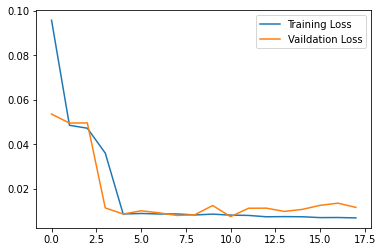

In [136]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Vaildation Loss')
plt.legend()
plt.show()

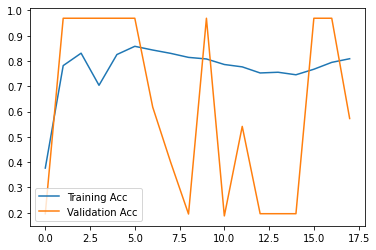

In [137]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.legend()
# plt.savefig('acc.png', dpi=300)
# plt.show()

In [138]:
# 임계값 정의 및 예측값과 복원 오차 확인
# 양품 및 불량 구분을 위한 임계치 설정
# 양품과 불량을 구분하기 위해서 잡음제거 오토인코더 모델을 각각 거치고 나온
# 양품데이터와 불랴데이터의 복원오차를 구별할 수 있는 임계치가 필요
# 양품 데이터로만 학습된 모델은 양품 데이터가 들어왔을 때 더 잘 복원해낼 것이므로
# 작은 복원 오차값을 가지지만, 불량 데이터가 들어왔을 때에는
# 덜 복원해내므로 높은 복원 오차값을 가지게 됨

# 해당 알고리즘에서는 임계치로 3시그마 규칙(three-sigma rule)을 적용
# 3시그마 규칙은 평균에서 양쪽으로 3표준편차 범위에 거의 모든 값들(99.7%)이
# 들어간다는 가정인데, 잡음제거 오토인코더 모델의 정상 데이터 예측값의 3시그마 이상의
# 값을 적용하여 임계치를 설정

In [139]:
# 학습 데이터의 예측값
cn7_train_pred = dropout_AE.predict(cn7_train_Y)

# 학습 데이터의 복원 오차(예측값 - 실제값)
cn7_train_loss = np.mean(np.square(cn7_train_pred - cn7_train_Y), axis=1)

# 임계치
threshold = np.mean(cn7_train_loss) + 5 * np.std(cn7_train_loss)

print('복원 오류 임계치', threshold)

복원 오류 임계치 0.047919177791709885


In [140]:
# 데이터 각각의 예측값과 복원오차 확인
# 평가 데이터의 양품 및 불량 데이터 각각의 예측값과 복원 오차를 확인
# 복원 오차가 임계치(threshold)보다 크면 모델이 익숙하지 않은 패턴을 보고 있음을
# 유추하고 해당 데이터를 불량이라고 판단할 수 있다

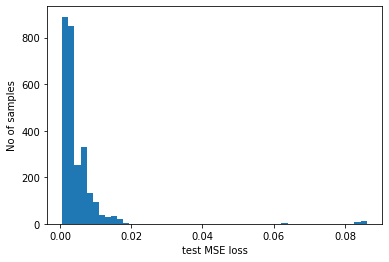

불량 개수 : 22


In [141]:
# 평가 데이터의 양품

# 예측값
cn7_predict_Y = dropout_AE.predict(cn7_test_Y)

# 양품 평가 데이터의 복원 오차(예측값 - 실제값)
cn7_test_Y_mse = np.mean(np.square(cn7_predict_Y - cn7_test_Y), axis=1)

# 시각화
plt.hist(cn7_test_Y_mse, bins=50)
plt.xlabel('test MSE loss')
plt.ylabel('No of samples')
plt.show()

# 불량으로 판단한 데이터 확인
cv7_test_Y_anomalies = cn7_test_Y_mse > threshold

print('불량 개수 :',np.sum(cv7_test_Y_anomalies))

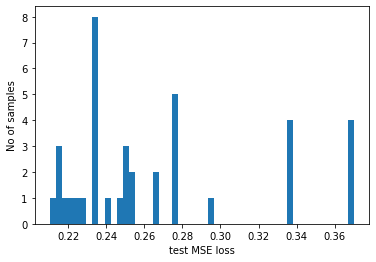

불량 개수: 39


In [143]:
# 평가 데이터의 불량

# 예측값
cn7_predict_N = dropout_AE.predict(cn7_test_N)

# 불량 평가 데이터의 복원 오차 (예측값 - 실제값)
cn7_test_N_mse = np.mean(np.square(cn7_predict_N - cn7_test_N), axis=1)

# 시각화
plt.hist(cn7_test_N_mse, bins=50)
plt.xlabel('test MSE loss')
plt.ylabel('No of samples')
plt.show()

# 불량으로 판단한 데이터 확인
cv7_test_N_anomalies = cn7_test_N_mse > threshold
print("불량 개수:",np.sum(cv7_test_N_anomalies))

In [144]:
# 결과 분석 및 해석
# 혼동 행렬(confusion matrix)로 결과를 확인하기 위해 평가 데이터의 양품과 불량을 결합
# 실게값과 예측값 형태로 정리

In [146]:
cn7_true = np.concatenate([np.zeros(len(cv7_test_Y_anomalies)), np.ones(len(cv7_test_N_anomalies))])

cn7_prediction = np.concatenate([cv7_test_Y_anomalies, cv7_test_N_anomalies])

In [147]:
# 혼동 행렬은 실제값과 예측값을 비교하는 데에 사용
# 정확도, 정밀도, 재현율은 혼동 행렬에 속하는 값으로 계산할 수 있음
# 혼동 행렬 내부에는 TP,TN,FP,FN 네 가지 값이 위치

# TN 은 정상(양품)의 클래스변수를 가진 데이터를 옳게 정상으로 예측한 개수
# FP 는 불량의 클래스변수를 가진 데이터를 정상으로 잘못 예측한 개수
# FN 은 정상의 클래스변수를 가진 데이터를 불량으로 잘못 예측한 개수

In [148]:
from sklearn.metrics import confusion_matrix
confusion_matrix(cn7_true, cn7_prediction)

array([[2675,   22],
       [   0,   39]])

In [149]:
# sklearn package에서 제공하는
# accuracy_score, precision_score, recall_score, f1_score 활용하여
# 정확도, 정밀도, 재현율 및 F1 score를 확인

In [150]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('정확도',accuracy_score(cn7_true, cn7_prediction))
print('정밀도',precision_score(cn7_true, cn7_prediction))
print('재현율',recall_score(cn7_true, cn7_prediction))
print('F1',f1_score(cn7_true, cn7_prediction))

정확도 0.9919590643274854
정밀도 0.639344262295082
재현율 1.0
F1 0.78


In [151]:
# 분석 결과에 대한 논의 및 해석
# 정확도는 높은 반면 그 외의 평가 지표 결과가 낮은 이유는 데이터 수의 부족이 될 수 있음
# 정확도의 경우 전체 데이터 중에서 옳게 분류한 개수를 의미하는 반면
# 그 이의 평가 지표는 정상 데이터 중에서, 혹은 불량데이터 중에서 옳게 분류한
# 데이터의 수를 계산함
# 그로 인해 해당 지표들은 특히 불량의 총 개수에 민감하게 바뀔 수 있는데
# 성능 결과가 낮다면 전반적인 성능을 높이기 위해서 불량 데이터의 수를 확보함으로 
# 보다 많은 정보를 모델에 학습시키고 덜 민감한 성능 지표를 갖도록 해야 함

# 정밀도와 재현율은 서로 트레이드 오프(trade-off)관계를 가지고 있음
# 이유는 정상과 불량을 구분하는 임계값이 줄어들면
# 정상을 불량이라고 판단한 개수인 FP의 수는 증가하지만 불량을 정상 데이터로 판단한
# FN이 감소하게 되어 정밀도는 감소하는 반면 재현율은 증가함
# 낮은 정밀도를 높이기 위해서 4시그마 혹은 5시그마로 임계값을 높이게 되면
# 정밀도는 개선될 수 있을지라도 재현율이 낮아지므로, 적잘한 정밀도와 재현율을
# 가질 수 있게 하는 임계값을 설정하는 것 또한 중요함